In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [129]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [131]:
df.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1281.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,59886.273224,2.976744,0.506108,0.619015
std,1.449717,15070.140389,1.681564,0.288465,0.485795
min,0.000000,13929.000000,0.000000,0.000000,0.000000
25%,1.000000,49698.000000,2.000000,0.262500,0.000000
50%,2.000000,60148.000000,3.000000,0.510000,1.000000
75%,3.000000,69639.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


In [132]:
# Check for missing values

print("\nMissing values per column:\n")
print(df.isnull().sum())


Missing values per column:

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [133]:
# Replace missing values - For categorical features:'NA'

categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna('NA')

# Replace missing values - For numeric features :0.0

numeric_cols = [col for col in df.columns if col not in categorical_cols]
df[numeric_cols] = df[numeric_cols].fillna(0.0)

In [134]:
# Data preparation
# Check if the missing values are presented in the features.
# If there are missing values:
# For caterogiral features, replace them with 'NA'
# For numerical features, replace with with 0.0
    
# Check for missing values

print("\nMissing values per column:\n")
print(df.isnull().sum())


Missing values per column:

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [135]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split function for that with random_state=1

full_train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=1)
print(f"Train Set: {len(train_df)} \nValidation Set: {len(val_df)} \nTest Set: {len(test_df)}")

Train Set: 876 
Validation Set: 293 
Test Set: 293


In [136]:
target = "converted"

categorical_columns = list(categorical_cols)
features = [col for col in numeric_cols + categorical_columns if col != target]

# Training set
X_train = train_df[features].reset_index(drop=True)
y_train = train_df[target].reset_index(drop=True)

# Validation set
X_val = val_df[features].reset_index(drop=True)
y_val = val_df[target].reset_index(drop=True)

# Test set
X_test = test_df[features].reset_index(drop=True)
y_test = test_df[target].reset_index(drop=True)

In [137]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(876, 8) (876,)
(293, 8) (293,)
(293, 8) (293,)


Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* lead_score
* number_of_courses_viewed
* interaction_count
* annual_income

In [138]:
numerics = features = [col for col in numeric_cols if col != target]
for col in numerics:
    auc = roc_auc_score(y_train, X_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, X_train[col])
    print(f"{col:<30}| AUC: {auc:.4f}")

number_of_courses_viewed      | AUC: 0.7636
annual_income                 | AUC: 0.5520
interaction_count             | AUC: 0.7383
lead_score                    | AUC: 0.6145


number_of_courses_viewed has the highest AUC

Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

* LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [139]:
# One-hot encoding
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(X_train.to_dict(orient="records"))
X_val = dv.transform(X_val.to_dict(orient="records"))

print(f"X_train Shape: {X_train.shape}, X_val Shape: {X_val.shape}")

X_train Shape: (876, 31), X_val Shape: (293, 31)


In [140]:
# Model Training 

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1_000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict_proba(X_val)[:, 1]

# AUC score
auc = roc_auc_score(y_val, y_pred)
print(f"Validation set AUC: {auc:.3f}")

Validation set AUC: 0.817


Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

In [141]:
# Thresholds definition
thresholds = np.arange(0.0, 1.01, 0.01)
scores = []

# Evaluate thresholds
for eval in thresholds:
    y_val_binary = (y_pred >= eval).astype(int)

    # Calculate Precision and Recall
    precision = precision_score(y_val, y_val_binary, zero_division=0)
    recall = recall_score(y_val, y_val_binary)

    scores.append((eval, precision, recall))

df_scores = pd.DataFrame(scores, columns=["threshold", "precision", "recall"])

# precision vs recall
df_scores["difference"] = np.abs(df_scores["precision"] - df_scores["recall"])

# Find the threshold where this difference is minimal
intersection_threshold = (df_scores.query("precision != 0 & recall != 0").sort_values(by="difference").head(1)["threshold"].values[0])
print(f"Intersection threshold: {intersection_threshold:.3f}")

Intersection threshold: 0.640


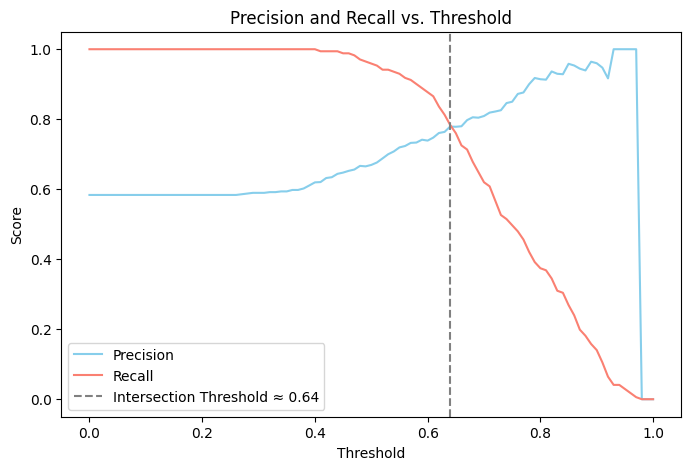

In [142]:
# Precision and Recall vs Threshold plot
plt.figure(figsize=(8, 5))

# Plot Precision
sns.lineplot(
    x="threshold",
    y="precision",
    data=df_scores,
    label="Precision",
    color="skyblue",
)

# Plot Recall
sns.lineplot(
    x="threshold",
    y="recall",
    data=df_scores,
    label="Recall",
    color="salmon",
)

# Mark the intersection threshold
plt.axvline(
    x=intersection_threshold,
    color="gray",
    linestyle="--",
    label=f"Intersection Threshold ≈ {intersection_threshold:.2f}",
)

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")

# Optional: remove grid
plt.grid(False)

# Legend
plt.legend()

# Show plot
plt.show()


Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

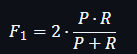

Where P is precision and  R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [143]:
df_scores["f1_score"] = (2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))
best_f1 = df_scores.iloc[np.argmax(df_scores.f1_score)]["threshold"]
print(f"F1 is maximal at threshold: {best_f1:.4f}")

F1 is maximal at threshold: 0.5700


Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation
* How large is standard deviation of the scores across different folds?

In [144]:
# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
fold_auc_scores = []

# Iterate over each fold
for train_indices, val_indices in kf.split(full_train_df):
    # Split data into fold-specific training and validation sets
    fold_train_df = full_train_df.iloc[train_indices]
    fold_val_df = full_train_df.iloc[val_indices]

    # Extract target arrays
    y_fold_train = fold_train_df[target].values
    y_fold_val = fold_val_df[target].values

    # Convert features to one-hot encoding
    vectorizer = DictVectorizer(sparse=False)
    X_fold_train = vectorizer.fit_transform(fold_train_df[features].to_dict(orient="records"))
    X_fold_val = vectorizer.transform(fold_val_df[features].to_dict(orient="records"))

    # Fit logistic regression on the training fold
    clf = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
    clf.fit(X_fold_train, y_fold_train)

    # Predict probabilities and calculate AUC for validation fold
    y_fold_pred = clf.predict_proba(X_fold_val)[:, 1]
    fold_auc_scores.append(roc_auc_score(y_fold_val, y_fold_pred))

# Calculate standard deviation of the fold AUCs
auc_std_dev = np.std(fold_auc_scores)

# Display results
print(f"AUC scores for each fold: {[score for score in fold_auc_scores]}")
print(f"AUC standard deviation: {auc_std_dev:.4f}")


AUC scores for each fold: [0.7897714583488423, 0.8520603643756353, 0.7644069121901634, 0.7872042341220424, 0.8494041170097508]
AUC standard deviation: 0.0356


Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [145]:
# Define different regularization strengths to test
C = [0.000001, 0.001, 1]

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store results
cv_summary = {}

# Iterate over each C value
for C_val in C:
    fold_aucs = []

    # Perform k-fold cross-validation
    for train_idx, val_idx in kf.split(full_train_df):
        # Split training and validation data for this fold
        fold_train = full_train_df.iloc[train_idx]
        fold_val = full_train_df.iloc[val_idx]

        # Extract target arrays
        y_fold_train = fold_train[target].values
        y_fold_val = fold_val[target].values

        # One-hot encode features
        vectorizer = DictVectorizer(sparse=False)
        X_fold_train = vectorizer.fit_transform(fold_train[features].to_dict(orient="records"))
        X_fold_val = vectorizer.transform(fold_val[features].to_dict(orient="records"))

        # Train logistic regression with current C
        clf = LogisticRegression(solver="liblinear", C=C_val, max_iter=1000)
        clf.fit(X_fold_train, y_fold_train)

        # Predict probabilities and compute AUC
        y_fold_pred = clf.predict_proba(X_fold_val)[:, 1]
        fold_aucs.append(roc_auc_score(y_fold_val, y_fold_pred))

    # Compute mean and standard deviation of AUC across folds
    mean_auc = np.mean(fold_aucs)
    std_auc = np.std(fold_aucs)

    # Save results for this C value
    cv_summary[C_val] = {"mean_auc": mean_auc, "std_auc": std_auc}

    # Display results
    print(f"C = {C_val:<5.6f} | Mean AUC = {mean_auc:.3f} | Std = {std_auc:.3f}")

C = 0.000001 | Mean AUC = 0.560 | Std = 0.024
C = 0.001000 | Mean AUC = 0.857 | Std = 0.030
C = 1.000000 | Mean AUC = 0.809 | Std = 0.036
